In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)  # Show all columns
#pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping
#pd.set_option('display.max_colwidth', None)  # Show full content of each column

import joblib

/Users/kruylimeng/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# 1.1. Collect credit card transaction data
df = pd.read_excel('dataset/dataset_v01.xlsx')

# Drop customerID since it's not useful for modeling
df = df.drop(columns=['customerID'], errors='ignore')

# cast variables where it makes sense
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

df_temp = df.copy()
df_temp.columns = [f"{col}, {idx}, {df_temp[col].nunique()}" for idx, col in enumerate(df_temp.columns)]
df_temp.head(5)

,"gender, 0, 2","SeniorCitizen, 1, 2","Partner, 2, 2","Dependents, 3, 2","tenure, 4, 73","PhoneService, 5, 2","MultipleLines, 6, 3","InternetService, 7, 3","OnlineSecurity, 8, 3","OnlineBackup, 9, 3","DeviceProtection, 10, 3","TechSupport, 11, 3","StreamingTV, 12, 3","StreamingMovies, 13, 3","Contract, 14, 3","PaperlessBilling, 15, 2","PaymentMethod, 16, 4","MonthlyCharges, 17, 1585","TotalCharges, 18, 6530","Churn, 19, 2"
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [4]:
# 1.2. Handle missing values and outliers
# 
# If missing values are few → Fill with median (less affected by outliers).
# If missing values are many → Fill with mean (if data is normally distributed).
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())  # Use median for robustness as only 11 values missing
#
# If the missing category means “No Service” (e.g., MultipleLines_No phone service) → Fill with "No".
# Otherwise, fill with the most frequent category (mode).
# df['PaymentMethod'] = df['PaymentMethod'].fillna(df['PaymentMethod'].mode()[0])
# df['InternetService'] = df['InternetService'].fillna("No")  # If it makes logical sense
#
# If missing values are random and small in number, dropping rows may be an option:
# df.dropna(inplace=True)

# 1.3. Perform exploratory data analysis (EDA)
eda_df = pd.DataFrame({
    'DType': df.dtypes,
    'Rows': df.shape[0],
    'Values': df.count(),
    'Unique': df.nunique(),
    'Miss': df.isnull().sum(),
    'Null': (df.isnull().sum() / len(df)) * 100,
    'min': df.describe().transpose()['min'].round(2),
    'max': df.describe().transpose()['max'].round(2),
    'mean': df.describe().transpose()['mean'].round(2),
    'sd': df.describe().transpose()['std'].round(2),
}).reindex(df.columns, axis=0)

eda_df.insert(0, 'Column Number', range(0, len(eda_df) ))
eda_df['Sample'] = df.iloc[:3].apply(lambda row: ', '.join(row.astype(str)), axis=0)
eda_df['Encoding'] = df.apply(lambda col: 'label' if col.dtype == 'object' and col.nunique() == 2 
                          else ('one-hot' if col.dtype == 'object' and col.nunique() > 2 else 'none'), axis=0)
eda_df.to_excel('report/01-eda.xlsx')
eda_df

,Column Number,DType,Rows,Values,Unique,Miss,Null,min,max,mean,sd,Sample,Encoding
gender,0,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"Female, Male, Male",label
SeniorCitizen,1,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"0, 0, 0",label
Partner,2,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"Yes, No, No",label
Dependents,3,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"No, No, No",label
tenure,4,int64,7043,7043,73,0,0.0,0.00,72.00,32.37,24.56,"1, 34, 2",none
PhoneService,5,object,7043,7043,2,0,0.0,NaN,NaN,NaN,NaN,"No, Yes, Yes",label
MultipleLines,6,object,7043,7043,3,0,0.0,NaN,NaN,NaN,NaN,"No phone service, No, No",one-hot
InternetService,7,object,7043,7043,3,0,0.0,NaN,NaN,NaN,NaN,"DSL, DSL, DSL",one-hot
OnlineSecurity,8,object,7043,7043,3,0,0.0,NaN,NaN,NaN,NaN,"No, Yes, Yes",one-hot
OnlineBackup,9,object,7043,7043,3,0,0.0,NaN,NaN,NaN,NaN,"Yes, No, Yes",one-hot


/var/folders/s4/llm0707d591b98f29rkwxcpc0000gn/T/ipykernel_50743/379924224.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette=['#2E86C1', '#E74C3C'])


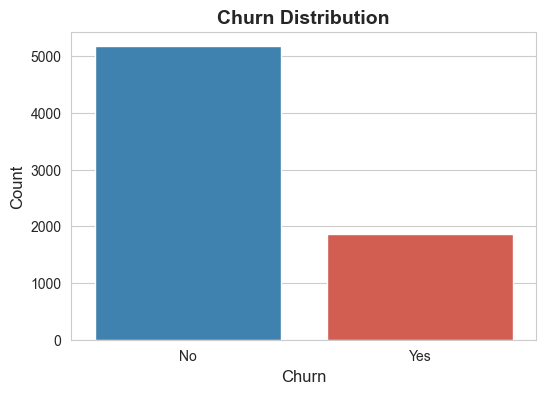

In [5]:
# VIZ
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set modern style
sns.set_style("whitegrid")
sns.set_palette("pastel")

# 1. Churn Distribution
plt.figure(figsize=(6,4))
# Set the background to transparent
plt.gcf().set_facecolor("none")  # Make the figure background transparent
plt.gca().set_facecolor("none")  # Make the axes background transparent

sns.countplot(x='Churn', data=df, palette=['#2E86C1', '#E74C3C'])
plt.title('Churn Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.savefig('report/image/01-churn-distribution.png', dpi=500, transparent=True)
plt.show()

In [6]:
# 1.4. Normalize or standardize numerical features
# df.columns

# Standardization (z-score method) → If using models like Logistic Regression, SVM, or ANN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

# Normalization (min-max scaling) → If using distance-based models like KNN or Neural Networks
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])'''

In [7]:
# 1.5. Encode categorical variables (OHE, label encoding) 
# Potential Data Leakage Concerns:
# -If encoding methods like one-hot encoding (OHE) or label encoding are used, they should be done before splitting, as they don’t rely on the dataset distribution.
# -If target encoding or mean encoding (which depend on target labels) is used, it must be done after splitting to avoid data leakage.

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label Encoding (for Binary/Ordinal Categories)
label_enc_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
le = LabelEncoder()

for col in label_enc_cols:
    df[col] = le.fit_transform(df[col])  # 0 or 1 encoding for binary categories

# One-Hot Encoding (for Nominal Categories)
ohe_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=ohe_cols, drop_first=True).astype(int) # drop_first=True to avoid multicollinearity

# Final Processed DataFrame
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1,0,1,-1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,-1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,-1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
df.shape

(7043, 31)

In [9]:
df_original = df.copy()
df_c1 = df[df['Churn'] == 1]
df_c0 = df[df['Churn'] == 0].sample(n=len(df_c1), random_state=42)
df = pd.concat([df_c0, df_c1], axis=0)
df.shape

(3738, 31)

In [10]:
X = df.drop(columns=['Churn']).values  # Features (all columns except 'Churn')
y = df['Churn'].values  # Target variable (Churn)

# 1.8. Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
X[0]

array([ 0,  0,  0,  0, -1,  1,  0, -1,  0,  0,  0,  0,  1,  1,  0,  1,  0,
        1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1])

In [12]:
# MODEL EVALUATION for comparing all models in end
def get_model_metrics(X_test, y_test, y_pred, model, model_name):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, mean_squared_error, r2_score

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()

    # Classification Report (Precision, Recall, F1-score, Support)
    report = classification_report(y_test, y_pred, output_dict=True)

    # ROC-AUC Score
    # Probabilities for positive class
    if hasattr(model, "predict_proba"):  # For models like Logistic Regression, Random Forest, etc.
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:  # For ANN or other models without predict_proba
        roc_auc = roc_auc_score(y_test, model.predict(X_test))

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Extract n_estimators and max_depth if they exist
    n_estimators = None
    max_depth = None

    if hasattr(model, "n_estimators"):  # For RandomForest, XGBoost, etc.
        n_estimators = model.n_estimators
    if hasattr(model, "max_depth"):  # For DecisionTree, RandomForest, XGBoost, etc.
        max_depth = model.max_depth

    # Compile all metrics into a dictionary
    metrics_dict = {
        "Model": [model_name],  # Add the model name
        "Confusion Matrix: TP": [TP],
        "Confusion Matrix: FP": [FP],
        "Confusion Matrix: FN": [FN],
        "Confusion Matrix: TN": [TN],
        "Confusion Matrix: TN-FP": [TN-FP],
        "Confusion Matrix: FN-FP": [FN-FP],
        "Confusion Matrix: TN-TP": [TN-TP],
        "Confusion Matrix: FN-TP": [FN-TP],
        "Classification Report: 0-precision": [report['0']['precision']],
        "Classification Report: 1-precision": [report['1']['precision']],
        "Classification Report: 0-recall": [report['0']['recall']],
        "Classification Report: 1-recall": [report['1']['recall']],
        "Classification Report: 0-f1-score": [report['0']['f1-score']],
        "Classification Report: 1-f1-score": [report['1']['f1-score']],
        "Classification Report: 0-support": [report['0']['support']],
        "Classification Report: 1-support": [report['1']['support']],
        "Classification Report: accuracy-f1-score": [report['accuracy']],
        "Classification Report: accuracy-support": [report['macro avg']['support']],
        "Classification Report: macro avg-precision": [report['macro avg']['precision']],
        "Classification Report: macro avg-recall": [report['macro avg']['recall']],
        "Classification Report: macro avg-f1-score": [report['macro avg']['f1-score']],
        "Classification Report: macro avg-support": [report['macro avg']['support']],
        "Classification Report: weighted avg-precision": [report['weighted avg']['precision']],
        "Classification Report: weighted avg-recall": [report['weighted avg']['recall']],
        "Classification Report: weighted avg-f1-score": [report['weighted avg']['f1-score']],
        "Classification Report: weighted avg-support": [report['weighted avg']['support']],
        "ROC-AUC Score": [roc_auc],
        "Accuracy": [accuracy],
        "MSE": [mse],
        "R2 Score": [r2],
        "N Estimators": n_estimators,
        "Max Depth": max_depth
    }

    # Convert the dictionary to a Pandas DataFrame
    metrics_df = pd.DataFrame(metrics_dict)
    
    return metrics_df

In [13]:
# Logistic regression
# Apply Logistic Regression with Class Balancing
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression model
model_logistic = LogisticRegression(class_weight='balanced', random_state=42)
model_logistic.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_logistic.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_logistic = get_model_metrics(X_test, y_test, y_pred, model_logistic, model_name='Logistic')

joblib.dump(model_logistic, 'model/testing/model_logistic.pkl')

['model/testing/model_logistic.pkl']

In [14]:

# INTERPRETABILITY

# Get coefficients
coefficients = model_logistic.coef_[0]  # Logistic Regression returns an array, so extract first element

# Compute odds ratios
odds_ratios = np.exp(coefficients)

# Create a DataFrame for better readability
feature_names = df.drop(columns=['Churn']).columns
odds_ratios_df = pd.DataFrame({'Feature': feature_names, 'Odds Ratio': odds_ratios})
odds_ratios_df.sort_values(by='Odds Ratio', ascending=False).to_excel('report/02-logistic-odds-ratios.xlsx')
print(odds_ratios_df.sort_values(by='Odds Ratio', ascending=False))  # Sort by impact

# EXAMPLE
#customer with fiber optic internet service has 2.19 times higher odds of churning compared to the reference group (DSL).
#customers who use electronic checks for payment have 1.55 times higher odds of churning compared to other payment methods.
#customers on a two-year contract have an 81.6% lower odds of churning compared to the reference group (1 - 0.184 = 81.6%)
#customers on a one-year contract have a 60.6% lower odds of churning compared to the reference group (1 - 0.394 = 60.6%).

                                  Feature  Odds Ratio
11            InternetService_Fiber optic    2.145842
28         PaymentMethod_Electronic check    1.633359
6                        PaperlessBilling    1.555914
24                    StreamingMovies_Yes    1.337121
22                        StreamingTV_Yes    1.325961
1                           SeniorCitizen    1.283789
8                            TotalCharges    1.245693
29             PaymentMethod_Mailed check    1.104671
7                          MonthlyCharges    1.088587
10                      MultipleLines_Yes    1.042599
9          MultipleLines_No phone service    1.035112
2                                 Partner    1.015555
27  PaymentMethod_Credit card (automatic)    0.962167
3                              Dependents    0.947365
18                   DeviceProtection_Yes    0.935538
0                                  gender    0.920870
17   DeviceProtection_No internet service    0.877220
19        TechSupport_No int

In [15]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train KNN model
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_knn.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_knn = get_model_metrics(X_test, y_test, y_pred, model_knn, model_name='K-NN')

joblib.dump(model_knn, 'model/testing/model_knn.pkl')

['model/testing/model_knn.pkl']

In [16]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Support Vector Machines (SVM)
from sklearn.svm import SVC

# Initialize and train SVM model
model_svm = SVC(class_weight='balanced', probability=True, random_state=42)
model_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_svm.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_svm = get_model_metrics(X_test, y_test, y_pred, model_svm, model_name='SVM')

joblib.dump(model_svm, 'model/testing/model_svm.pkl')

['model/testing/model_svm.pkl']

In [17]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Kernel Support Vector Machines (Kernel SVM)

from sklearn.svm import SVC

# Initialize and train Kernel SVM model
model_kernel_svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
model_kernel_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_kernel_svm.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_ksvm = get_model_metrics(X_test, y_test, y_pred, model_kernel_svm, model_name='Kernel SVM')

joblib.dump(model_kernel_svm, 'model/testing/model_kernel_svm.pkl')


['model/testing/model_kernel_svm.pkl']

In [18]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Naive Bayes

from sklearn.naive_bayes import GaussianNB

# Initialize and train Naive Bayes model
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_nb.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_nb = get_model_metrics(X_test, y_test, y_pred, model_nb, model_name='Naive Bayes')

joblib.dump(model_nb, 'model/testing/model_nb.pkl')

['model/testing/model_nb.pkl']

In [19]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Initialize and train Decision Tree model
model_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)
model_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_dt.predict(X_test)

# EVALUATION FOR COMPARISON 
eval_dt = get_model_metrics(X_test, y_test, y_pred, model_dt, model_name='Decision Trees')

joblib.dump(model_dt, 'model/testing/model_dt.pkl')

['model/testing/model_dt.pkl']

In [20]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classification 
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest Classifier model
model_random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=42)

# Train the model
model_random_forest.fit(X_train, y_train)

# EVALUATION FOR COMPARISON
eval_random_forest = get_model_metrics(X_test, y_test, y_pred, model_random_forest, model_name='Random Forest')

joblib.dump(model_random_forest, 'model/testing/model_random_forest.pkl')

['model/testing/model_random_forest.pkl']

In [21]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# !pip install xgboost
import xgboost as xgb

# Initialize the XGBoost classifier
model_xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)

# Train the model
model_xgboost.fit(X_train, y_train)

# Make predictions
y_pred = model_xgboost.predict(X_test)

# EVALUATION FOR COMPARISON
eval_xgboost = get_model_metrics(X_test, y_test, y_pred, model_xgboost, model_name='XGBoost')

joblib.dump(model_xgboost, 'model/testing/model_xgboost.pkl')

/Users/kruylimeng/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:28:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['model/testing/model_xgboost.pkl']

In [22]:
X_test[0]

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0])

In [23]:
# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ARTIFICIAL NEURAL NETWORKS
import tensorflow as tf

# Disable GPU (Optional)
tf.config.set_visible_devices([], 'GPU')  # Disable default GPU setting

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is now enabled with Metal API")
    

# Define the ANN model
model_ann_10 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),  # Another hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_ann_10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_ann_10.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = (model_ann_10.predict(X_test) > 0.5).astype(int)

# EVALUATION FOR COMPARISON
eval_ann_10 = get_model_metrics(X_test, y_test, y_pred, model_ann_10, model_name='ANN (10 Epochs)')

model_ann_10.save('model/testing/model_ann_10.keras')

GPU is now enabled with Metal API
Epoch 1/10


/Users/kruylimeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6600 - loss: 0.6251 - val_accuracy: 0.7647 - val_loss: 0.4906
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7634 - loss: 0.4955 - val_accuracy: 0.7674 - val_loss: 0.4774
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.7743 - loss: 0.4805 - val_accuracy: 0.7674 - val_loss: 0.4764
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.7762 - loss: 0.4731 - val_accuracy: 0.7701 - val_loss: 0.4766
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.7744 - loss: 0.4676 - val_accuracy: 0.7660 - val_loss: 0.4737
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.7786 - loss: 0.4542 - val_accuracy: 0.7754 - val_loss: 0.4782
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.7917 - loss: 0.4424 - val_accuracy: 0.7781 - val_loss: 0.4777
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7867 - loss: 0.4542 - val_accuracy: 0.7754 - val_loss

In [24]:
# MORE EPOCHS BETTER RESULT? OVERFITTING?

# reset variables just in case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ARTIFICIAL NEURAL NETWORKS ----- 25 EPOCHS
# import tensorflow as tf

# Define the ANN model
model_ann_25 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),  # Another hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_ann_25.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_ann_25.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = (model_ann_25.predict(X_test) > 0.5).astype(int)

# EVALUATION FOR COMPARISON
eval_ann_25 = get_model_metrics(X_test, y_test, y_pred, model_ann_25, model_name='ANN (25 Epochs)')

model_ann_25.save('model/testing/model_ann_25.keras')
joblib.dump(model_ann_25, 'model/testing/model_ann_25.pkl')

Epoch 1/25


/Users/kruylimeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6906 - loss: 0.6023 - val_accuracy: 0.7607 - val_loss: 0.4901
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.7701 - loss: 0.4854 - val_accuracy: 0.7741 - val_loss: 0.4790
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.7681 - loss: 0.4856 - val_accuracy: 0.7687 - val_loss: 0.4763
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.7635 - loss: 0.4762 - val_accuracy: 0.7701 - val_loss: 0.4755
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7966 - loss: 0.4480 - val_accuracy: 0.7687 - val_loss: 0.4794
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7925 - loss: 0.4500 - val_accuracy: 0.7687 - val_loss: 0.4784
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.7768 - loss: 0.4682 - val_accuracy: 0.7714 - val_loss: 0.4749
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7895 - loss: 0.4540 - val_accuracy: 0.7674 - val_loss

['model/testing/model_ann_25.pkl']

In [25]:
eval_final = pd.concat([eval_logistic, eval_knn, eval_svm, eval_ksvm, eval_nb, eval_dt, eval_random_forest, eval_xgboost, eval_ann_10, eval_ann_25], ignore_index=True)
eval_final

,Model,Confusion Matrix: TP,Confusion Matrix: FP,Confusion Matrix: FN,Confusion Matrix: TN,Confusion Matrix: TN-FP,Confusion Matrix: FN-FP,Confusion Matrix: TN-TP,Confusion Matrix: FN-TP,Classification Report: 0-precision,Classification Report: 1-precision,Classification Report: 0-recall,Classification Report: 1-recall,Classification Report: 0-f1-score,Classification Report: 1-f1-score,Classification Report: 0-support,Classification Report: 1-support,Classification Report: accuracy-f1-score,Classification Report: accuracy-support,Classification Report: macro avg-precision,Classification Report: macro avg-recall,Classification Report: macro avg-f1-score,Classification Report: macro avg-support,Classification Report: weighted avg-precision,Classification Report: weighted avg-recall,Classification Report: weighted avg-f1-score,Classification Report: weighted avg-support,ROC-AUC Score,Accuracy,MSE,R2 Score,N Estimators,Max Depth
0,Logistic,292,89,82,285,196,-7,-7,-210,0.776567,0.766404,0.762032,0.780749,0.769231,0.773510,374.0,374.0,0.771390,748.0,0.771485,0.771390,0.771370,748.0,0.771485,0.771390,0.771370,748.0,0.850446,0.771390,0.228610,0.085561,None,None
1,K-NN,273,117,101,257,140,-16,-16,-172,0.717877,0.700000,0.687166,0.729947,0.702186,0.714660,374.0,374.0,0.708556,748.0,0.708939,0.708556,0.708423,748.0,0.708939,0.708556,0.708423,748.0,0.789388,0.708556,0.291444,-0.165775,None,None
2,SVM,282,85,92,289,204,7,7,-190,0.758530,0.768392,0.772727,0.754011,0.765563,0.761134,374.0,374.0,0.763369,748.0,0.763461,0.763369,0.763348,748.0,0.763461,0.763369,0.763348,748.0,0.842082,0.763369,0.236631,0.053476,None,None
3,Kernel SVM,282,85,92,289,204,7,7,-190,0.758530,0.768392,0.772727,0.754011,0.765563,0.761134,374.0,374.0,0.763369,748.0,0.763461,0.763369,0.763348,748.0,0.763461,0.763369,0.763348,748.0,0.842082,0.763369,0.236631,0.053476,None,None
4,Naive Bayes,328,154,46,220,66,-108,-108,-282,0.827068,0.680498,0.588235,0.877005,0.687500,0.766355,374.0,374.0,0.732620,748.0,0.753783,0.732620,0.726928,748.0,0.753783,0.732620,0.726928,748.0,0.826310,0.732620,0.267380,-0.069519,None,None
5,Decision Trees,289,100,85,274,174,-15,-15,-204,0.763231,0.742931,0.732620,0.772727,0.747613,0.757536,374.0,374.0,0.752674,748.0,0.753081,0.752674,0.752574,748.0,0.753081,0.752674,0.752574,748.0,0.833746,0.752674,0.247326,0.010695,None,5
6,Random Forest,289,100,85,274,174,-15,-15,-204,0.763231,0.742931,0.732620,0.772727,0.747613,0.757536,374.0,374.0,0.752674,748.0,0.753081,0.752674,0.752574,748.0,0.753081,0.752674,0.752574,748.0,0.838150,0.752674,0.247326,0.010695,100,10
7,XGBoost,273,104,101,270,166,-3,-3,-172,0.727763,0.724138,0.721925,0.729947,0.724832,0.727031,374.0,374.0,0.725936,748.0,0.725950,0.725936,0.725931,748.0,0.725950,0.725936,0.725931,748.0,0.807730,0.725936,0.274064,-0.096257,100,10
8,ANN (10 Epochs),304,101,70,273,172,-31,-31,-234,0.795918,0.750617,0.729947,0.812834,0.761506,0.780488,374.0,374.0,0.771390,748.0,0.773268,0.771390,0.770997,748.0,0.773268,0.771390,0.770997,748.0,0.852176,0.771390,0.228610,0.085561,None,None
9,ANN (25 Epochs),284,85,90,289,204,5,5,-194,0.762533,0.769648,0.772727,0.759358,0.767596,0.764468,374.0,374.0,0.766043,748.0,0.766090,0.766043,0.766032,748.0,0.766090,0.766043,0.766032,748.0,0.847601,0.766043,0.233957,0.064171,None,None


In [26]:
eval_final.to_excel('report/03-eval-final.xlsx', index=False)

/var/folders/s4/llm0707d591b98f29rkwxcpc0000gn/T/ipykernel_50743/3620751815.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=eval_final, palette="coolwarm")


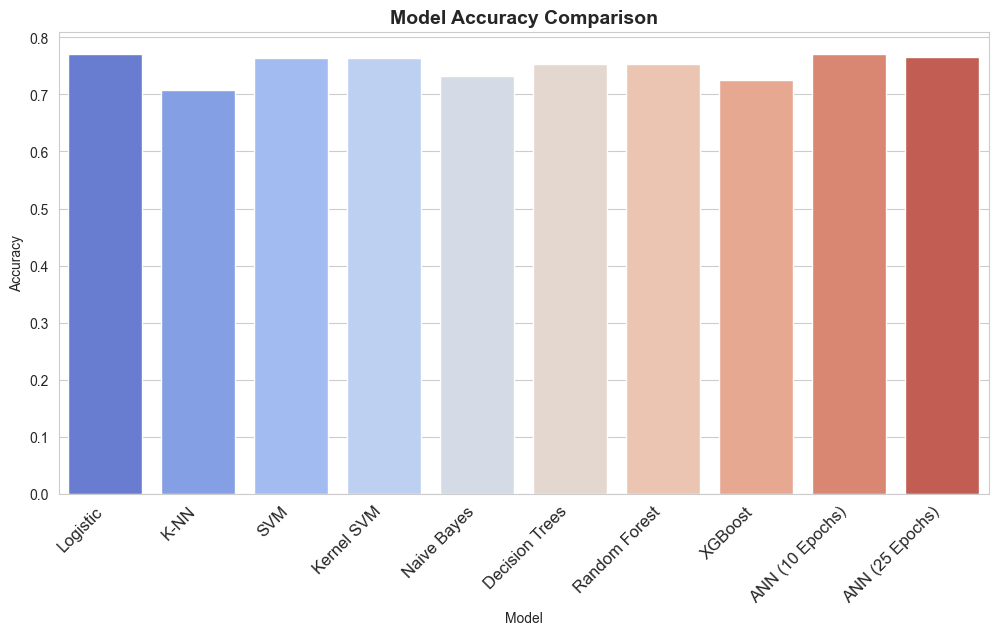

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set dark theme
# sns.set_theme(style="darkgrid")
# plt.style.use("dark_background")

# 1. Bar Chart: Model Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Accuracy", data=eval_final, palette="coolwarm")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.savefig('report/image/02-model-accuracy.png', dpi=500, transparent=True)
plt.show()

/var/folders/s4/llm0707d591b98f29rkwxcpc0000gn/T/ipykernel_50743/3590557766.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Metric", y="Score", data=df_melted, palette="mako")


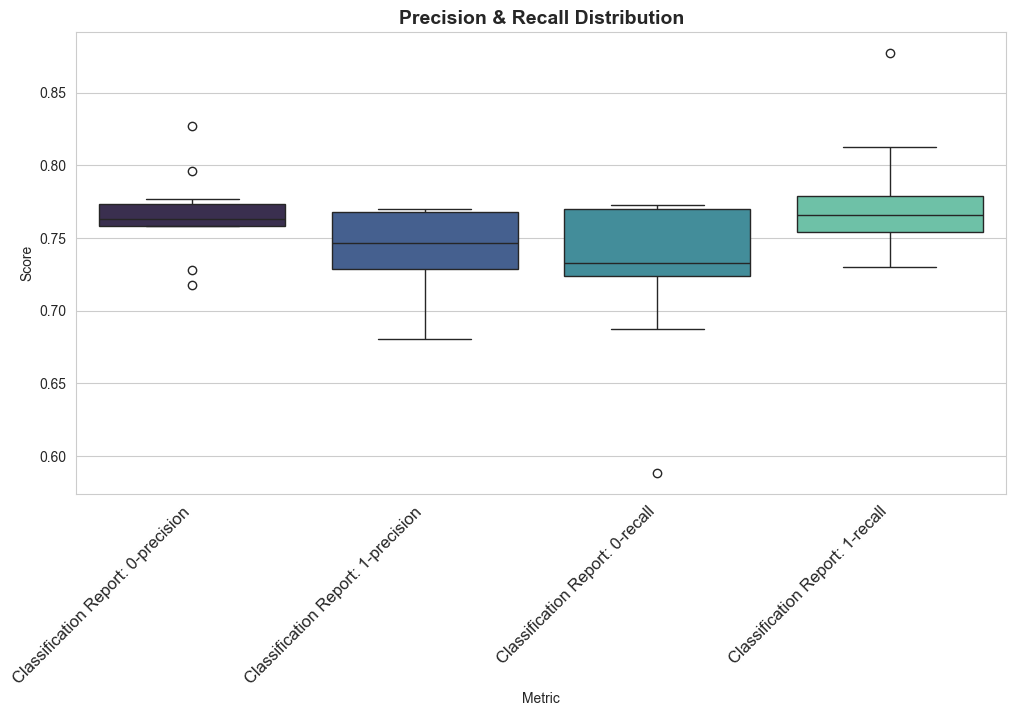

In [28]:
# 2. Box Plot: Precision & Recall Distribution
plt.figure(figsize=(12, 6))
df_melted = eval_final.melt(id_vars=["Model"], value_vars=["Classification Report: 0-precision", "Classification Report: 1-precision", "Classification Report: 0-recall", "Classification Report: 1-recall"], var_name="Metric", value_name="Score")
sns.boxplot(x="Metric", y="Score", data=df_melted, palette="mako")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("Precision & Recall Distribution", fontsize=14, fontweight="bold")
plt.savefig('report/image/03-precision-recall.png', dpi=500, transparent=True)
plt.show()

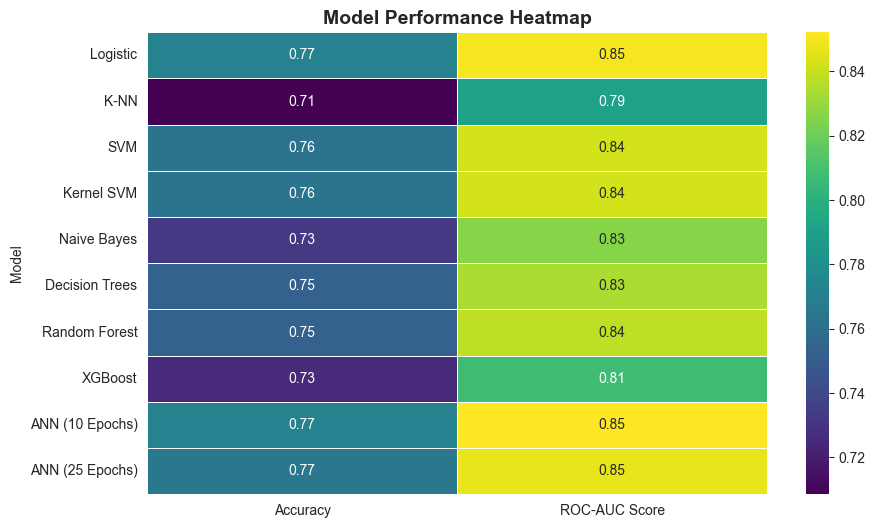

In [29]:
# 3. Heatmap: Accuracy & ROC-AUC
plt.figure(figsize=(10, 6))
sns.heatmap(eval_final.set_index("Model")[['Accuracy', 'ROC-AUC Score']], annot=True, cmap="viridis", linewidths=0.5)
plt.title("Model Performance Heatmap", fontsize=14, fontweight="bold")
plt.savefig('report/image/04-heatmap.png', dpi=500, transparent=True)
plt.show()

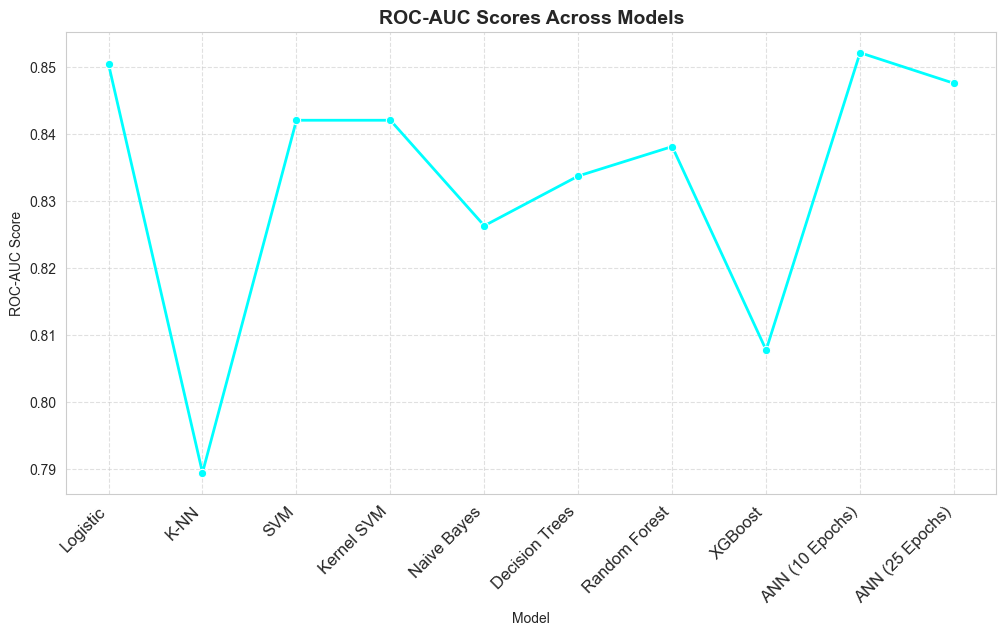

In [30]:
# 4. Line Chart: ROC-AUC Trend
plt.figure(figsize=(12, 6))
sns.lineplot(x="Model", y="ROC-AUC Score", data=eval_final, marker="o", color="cyan", linewidth=2)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("ROC-AUC Scores Across Models", fontsize=14, fontweight="bold")
plt.ylabel("ROC-AUC Score")
plt.xlabel("Model")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig('report/image/05-roc-auc-trend.png', dpi=500, transparent=True)
plt.show()

In [31]:
# End!